# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Geometric Transforms

In [5]:
def hat(v):
    """
    Computes the skew-symmetric matrix (hatmap) of a vector v.
    :param v: 3x1 vector (numpy array)
    :return: 3x3 skew-symmetric matrix
    """
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def vee(A):
    """
    The 'vee' operator is the inverse of the hat map:
      If A = hat(w), then vee(A) = w.
    This extracts the vector w = (A[2,1], A[0,2], A[1,0])^T
    from the 3x3 skew-symmetric matrix A.
    """
    return np.array([A[2, 1], A[0, 2], A[1, 0]])

def expm_so3(A):
    """
    Computes exp(A) for A in so(3) using Rodrigues' rotation formula.
    
    A must be a 3x3 skew-symmetric matrix: A^T = -A.
    The result is a 3x3 rotation matrix in SO(3).
    """
    # Extract the axis-angle vector w from A via the 'vee' operator
    w = vee(A)
    theta = np.linalg.norm(w)  # angle is the norm of w

    # If theta is very small, use a first-order Taylor expansion:
    #   exp(A) ≈ I + A
    # to avoid division by zero.
    if theta < 1e-12:
        return np.eye(3) + A

    # Rodrigues’ formula: R = I + (sinθ/θ) A + ((1 - cosθ)/θ²) A²
    I = np.eye(3)
    A2 = A @ A
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    R = (
        I
        + (sin_theta / theta) * A
        + ((1.0 - cos_theta) / (theta**2)) * A2
    )
    return R

def logm_so3(R):
    """
    Computes the logarithmic map for a rotation matrix R in SO(3).
    :param R: 3x3 rotation matrix in SO(3)
    :return: 3x3 skew-symmetric matrix in so(3)
    """
    # Ensure R is close to a valid rotation matrix
    assert np.allclose(R @ R.T, np.eye(3)), "R must be orthogonal: R * R^T = I"
    assert np.isclose(np.linalg.det(R), 1.0), "R must have determinant 1"

    # Compute the angle of rotation using the trace of R
    theta = np.arccos((np.trace(R) - 1) / 2.0)

    # If theta is very small, use a first-order approximation:
    # log(R) ≈ R - I
    if np.isclose(theta, 0):
        return R - np.eye(3)

    # Otherwise, compute log(R) using the formula:
    # log(R) = (θ / (2 * sin(θ))) * (R - R.T)
    log_R = (theta / (2 * np.sin(theta))) * (R - R.T)
    return log_R

In [6]:
def deriv_unit_vector(q, q_dot, q_ddot):
    nq = np.linalg.norm(q)
    b = q / nq
    b_dot = q_dot / nq - (q * np.dot(q, q_dot)/(nq**3))
    term1 = q_ddot / nq
    term2 = (q_dot / (nq**3))*(2.0*np.dot(q,q_dot))
    term3 = (q/(nq**3))*(np.dot(q_dot,q_dot)+np.dot(q,q_ddot))
    term4 = 3.0*q*(np.dot(q,q_dot)**2)/(nq**5)
    b_ddot = term1 - term2 - term3 + term4
    return b, b_dot, b_ddot

# Equations

In [7]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt


def desired_x(t):
    waypoints = np.array([
    [0, 0, 0],
    [1.0, 1.0, 0.0],
    [2.0, 1.0, 0.0],
    [4.0, 2.0, 0.0],
    [5.5, 1.5, 0.0],
    [6.0, 3.0, 0.0],
    [7.0, 5.0, 1.0],
    [10.0, 7.0, 2.0],
    [12.0, 10.0, 3.0],
    [12.0, 10.0, 3.0]
    ])

    time_stamps = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])  # First time is 0, rest are custom.

    # Define boundary condition for zero velocity at start and end.
    # The tuple format ((order, value), (order, value)) specifies derivative constraints.
    bc = ([(1, 0.0)], [(1, 0.0)])

    # Create cubic B-spline interpolators for each dimension.
    spline_x = make_interp_spline(time_stamps, waypoints[:, 0], bc_type=bc, k=3)
    spline_y = make_interp_spline(time_stamps, waypoints[:, 1], bc_type=bc, k=3)
    spline_z = make_interp_spline(time_stamps, waypoints[:, 2], bc_type=bc, k=3)

    # Evaluate derivatives (velocity components) on the fine grid using the derivative() method.

    xd = np.array([spline_x(t), spline_y(t), spline_z(t)])
    vd = np.array([spline_x.derivative(1)(t), spline_y.derivative(1)(t), spline_z.derivative(1)(t)])
    ad = np.array([spline_x.derivative(2)(t), spline_y.derivative(2)(t), spline_z.derivative(2)(t)])
    jd = np.array([spline_x.derivative(3)(t), spline_y.derivative(3)(t), spline_z.derivative(3)(t)])
    sd = np.array([0, 0, 0])

    return xd, vd, ad, jd, sd

In [8]:
def desired_head(t):
    
    b1d = np.array([1, 0, 0])
    b1d_dot = np.array([0, 0, 0])
    b1d_ddot = np.array([0, 0, 0])

    return b1d, b1d_dot, b1d_ddot

In [9]:
def Trajectory_control(parameters, controller, x, v, R, omega):
    parameters = parameters.copy()
    m = parameters["mass"]
    t = parameters["time"]

    k_x, k_v = controller["position"]

    xd, vd, ad, jd, sd = desired_x(t)

    error_x = x - xd
    error_v = v - vd

    A = (-k_x * error_x - k_v * error_v - m * 9.81 * np.array([0, 0, 1]) + m * ad)
    e3 = np.array([0, 0, 1])
    b3 = R @ e3
    f = np.dot(-A, b3)

    error_a = 9.81 * e3 - f / m * b3 - ad

    A_dot = - k_x * error_v - k_v * error_a + m * jd

    b3_dot = R @ hat(omega) @ e3
    f_dot = -np.dot(A_dot, b3) - np.dot(A, b3_dot)
    eb = - f_dot / m * b3 - f / m * b3_dot - jd

    A_ddot = - k_x * error_a - k_v * eb + m * sd

    b3d, b3d_dot, b3d_ddot = deriv_unit_vector(-A, -A_dot, -A_ddot)
    b1d, b1d_dot, b1d_ddot = desired_head(t)

    A2 = -hat(b1d) @ b3d
    A2_dot = -hat(b1d_dot) @ b3d - hat(b1d) @ b3d_dot
    A2_ddot = - hat(b1d_ddot) @ b3d - 2 * hat(b1d_dot) @ b3d_dot - hat(b1d) @ b3d_ddot;

    b2d, b2d_dot, b2d_ddot = deriv_unit_vector(A2, A2_dot, A2_ddot)


    b1c = hat(b2d) @ b3d;
    b1c_dot = hat(b2d_dot) @ b3d + hat(b2d) @ b3d_dot;
    b1c_ddot = hat(b2d_ddot) @ b3d + 2 * hat(b2d_dot) @ b3d_dot + hat(b2d) @ b3d_ddot;

    Rc = np.array([b1c, b2d, b3d]).T
    Rc_dot = np.array([b1c_dot, b2d_dot, b3d_dot]).T
    Rc_ddot = np.array([b1c_ddot, b2d_ddot, b3d_ddot]).T

    return f, Rc, Rc_dot, Rc_ddot

In [10]:
def Attitude_control(parameters, controller, R, omega, Rc, Rc_dot, Rc_ddot):
    parameters = parameters.copy()
    m = parameters["mass"]
    J = parameters["inertia"]
    t = parameters["time"]

    k_R, k_omega = controller['attitude']

    omegad = vee(Rc.T @ Rc_dot)
    omegad_dot = vee(Rc.T @ Rc_ddot - hat(omegad) @ hat(omegad))

    error_R = 1/2 * vee( Rc.T @ R - R.T @ Rc )
    error_omega = omega - R.T @ Rc @ omegad

    attitude_error = 1/2 * np.trace(np.eye(3) - Rc.T@R)

    M = -k_R * error_R - k_omega * error_omega + np.cross(omega, J@omega) - J @ (hat(omega) @ R.T @ Rc @ omegad - R.T @ Rc @ omegad_dot)
    
    return M, omegad, attitude_error

In [11]:
def discrete_dynamics(parameters, x, v, R, omega, f, M):
    m = parameters["mass"]
    J = parameters["inertia"]
    h = parameters["time_step"]

    g = 9.81
    e3 = np.array([0.0, 0.0, 1.0])

    def dynamics(x_, v_, R_, w_):
            """
            Returns (dx/dt, dv/dt, dR/dt, dw/dt) given (x, v, R, omega).
            """
            dxdt = v_
            dvdt = g*e3 - f / m * R_ @ e3  # mg e3 - f R e3

            # Rdot = R * skew(omega)
            dRdt = R_ @ hat(w_)

            # omegadot = J^{-1} ( M - omega x (J omega) )
            w_cross_Jw = np.cross(w_, J @ w_)
            dwdt = np.linalg.inv(J) @ (M - w_cross_Jw)

            return dxdt, dvdt, dRdt, dwdt
    
    k1_x, k1_v, k1_R, k1_w = dynamics(x, v, R, omega)

    #--------------------------------------------------------------------------
    # 2) Evaluate k2 (using the half-step state)
    #--------------------------------------------------------------------------
    x2     = x     + 0.5*h*k1_x
    v2     = v     + 0.5*h*k1_v
    R2     = R     + 0.5*h*k1_R
    w2     = omega + 0.5*h*k1_w

    k2_x, k2_v, k2_R, k2_w = dynamics(x2, v2, R2, w2)

    x3     = x     + 0.5*h*k2_x
    v3     = v     + 0.5*h*k2_v
    R3     = R     + 0.5*h*k2_R
    w3     = omega + 0.5*h*k2_w

    k3_x, k3_v, k3_R, k3_w = dynamics(x3, v3, R3, w3)


    x4     = x     + h*k3_x
    v4     = v     + h*k3_v
    R4     = R     + h*k3_R
    w4     = omega + h*k3_w

    k4_x, k4_v, k4_R, k4_w = dynamics(x4, v4, R4, w4)

    x_next = x + (h/6.0)*(k1_x + 2.0*k2_x + 2.0*k3_x + k4_x)
    v_next = v + (h/6.0)*(k1_v + 2.0*k2_v + 2.0*k3_v + k4_v)
    R_next = R + (h/6.0)*(k1_R + 2.0*k2_R + 2.0*k3_R + k4_R)
    w_next = omega + (h/6.0)*(k1_w + 2.0*k2_w + 2.0*k3_w + k4_w)

    return (x_next, v_next, R_next, w_next)


In [12]:
# Quadrotor physical parameters
mass = 4.34  # Mass of the quadrotor in kg
inertia = np.diag([0.0820, 0.0845, 0.1377])  # Moment of inertia matrix (diagonal)


# Initial state
x0 = np.array([0.0, 0.0, 0.0])  # Initial position (m)
v0 = np.array([0.0, 0.0, 0.0])  # Initial velocity (m/s)
R0 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]
])            # Initial rotation matrix (identity matrix)
omega0 = np.array([0.0, 0.0, 0.0])  # Initial angular velocity (rad/s)


h = 0.001  # Time step (seconds)
k = 1
time = 18
t = 0

# Parameter dictionary
params = {
    "mass": mass,
    "inertia": inertia,
    "time_step": h,
    "time": t,
    "total_time": time,
    "current_step": k,
}

controller = {
    "position": np.array([16, 5.6]),
    "attitude": np.array([8.81, 2.54])
}



In [18]:
def simulate(params, controller, x0, v0, R0, omega0):
    x_c, v_c, R_c, omega_c = x0, v0, R0, omega0
    x_1 = np.array(x0[0])
    x_2 = np.array(x0[1])
    x_3 = np.array(x0[2])

    xd_1 = np.array([])
    xd_2 = np.array([])
    xd_3 = np.array([])

    omega1 = np.array(omega0[0])
    omega2 = np.array(omega0[1])
    omega3 = np.array(omega0[2])

    omegad1 = np.array([])
    omegad2 = np.array([])
    omegad3 = np.array([])

    er = np.array([])

    time_stamp = np.array(0)

    cost = 0
    cost_array = np.array([])

    kinetic_energy_array = []
    potential_energy_array = []
    total_energy_array = []
    T1_list, T2_list, T3_list, T4_list = [], [], [], []
    d = 0.315
    ct = 8.004e-4
    matrix = np.array([
        [1,   1,  1,   1  ],
        [0,  -d,  0,   d  ],
        [d,   0, -d,   0  ],
        [-ct, ct, -ct, ct ]])
    mat_inv = np.linalg.inv(matrix)

    for i in range(int(params["total_time"]/params["time_step"])):
        
        f, Rc, Rc_dot, Rc_ddot = Trajectory_control(params, controller, x_c, v_c, R_c, omega_c)
        M, omegad, attitude_error = Attitude_control(params, controller, R_c, omega_c, Rc, Rc_dot, Rc_ddot)
        (x_c, v_c, R_c, omega_c) = discrete_dynamics(params, x_c, v_c, R_c, omega_c, f, M)

        x_1 = np.append(x_1, x_c[0])
        x_2 = np.append(x_2, x_c[1])
        x_3 = np.append(x_3, x_c[2])

        xd, _, _, _, _ = desired_x(params["time"])
        xd_1 = np.append(xd_1, xd[0])
        xd_2 = np.append(xd_2, xd[1])
        xd_3 = np.append(xd_3, xd[2])

        omega1 = np.append(omega1, omega_c[0])
        omega2 = np.append(omega2, omega_c[1])
        omega3 = np.append(omega3, omega_c[2])

        omegad1 = np.append(omegad1, omegad[0])
        omegad2 = np.append(omegad2, omegad[1])
        omegad3 = np.append(omegad3, omegad[2])

        er = np.append(er, attitude_error)
        cost += h/2 * (f**2 + np.dot(M, M))
        cost_array = np.append(cost_array, h/2 * (f**2 + np.dot(M, M)))

        v_vec = np.array(v_c)
        translational_ke = 0.5 * params["mass"] * np.dot(v_vec, v_vec)
        
        # Rotational kinetic energy: 0.5 * omega^T * I * omega
        omega_vec = np.array(omega_c)
        rotational_ke = 0.5 * np.dot(omega_vec, params['inertia'].dot(omega_vec))
        
        kinetic_energy = translational_ke + rotational_ke
        potential_energy = params["mass"] * 9.81 * x_c[2]  # Assuming x3 is vertical
        total_energy = kinetic_energy + potential_energy
        
        kinetic_energy_array.append(kinetic_energy)
        potential_energy_array.append(potential_energy)
        total_energy_array.append(total_energy)
        T_vec = mat_inv @ np.array([f, M[0], M[1], M[2]])
        T1_list.append(T_vec[0])
        T2_list.append(T_vec[1])
        T3_list.append(T_vec[2])
        T4_list.append(T_vec[3])

        params["time"] += params["time_step"]
        time_stamp = np.append(time_stamp, params["time"])
        params["current_step"] += 1
    print("Final Cost:", cost)
    T1_list = np.array(T1_list)
    T2_list = np.array(T2_list)
    T3_list = np.array(T3_list)
    T4_list = np.array(T4_list)
    return x_1, x_2, x_3, xd_1, xd_2, xd_3, omega1, omega2, omega3, omegad1, omegad2, omegad3 , er, time_stamp, cost, cost_array, kinetic_energy_array, total_energy_array, T1_list, T2_list, T3_list, T4_list

# Visualization

In [19]:
x_1, x_2, x_3, xd_1, xd_2, xd_3, omega1, omega2, omega3, omegad1, omegad2, omegad3 , er, time_stamp, cost, cost_array, kinetic_energy, total_energy, T1_list, T2_list, T3_list, T4_list = simulate(params, controller, x0, v0, R0, omega0)

Final Cost: 16404.591747057857


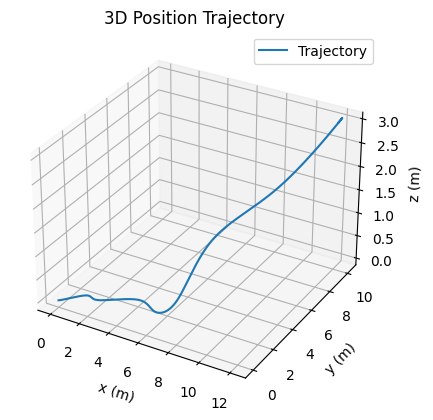

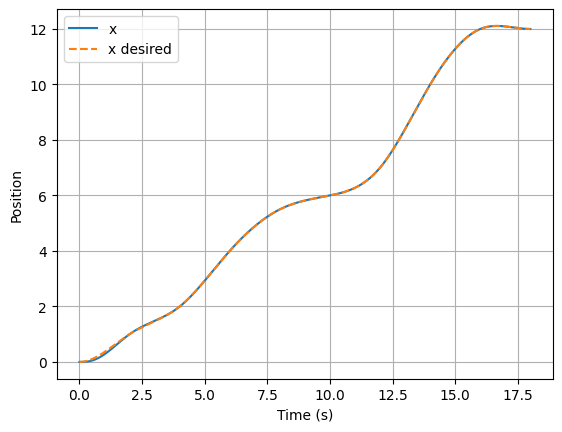

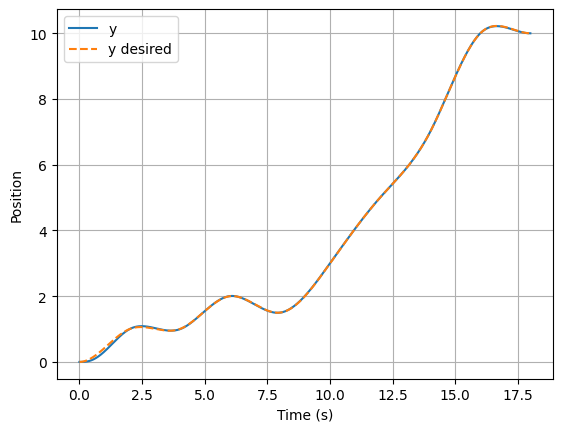

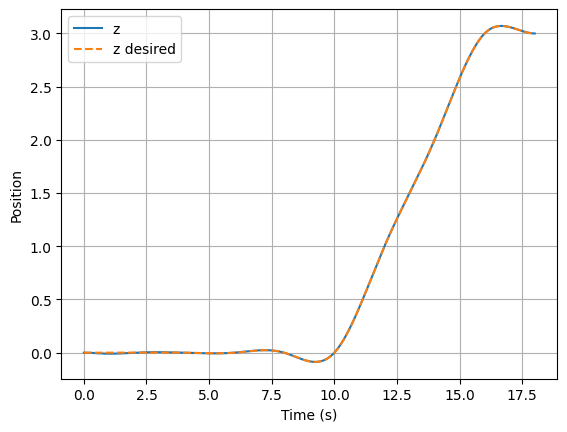

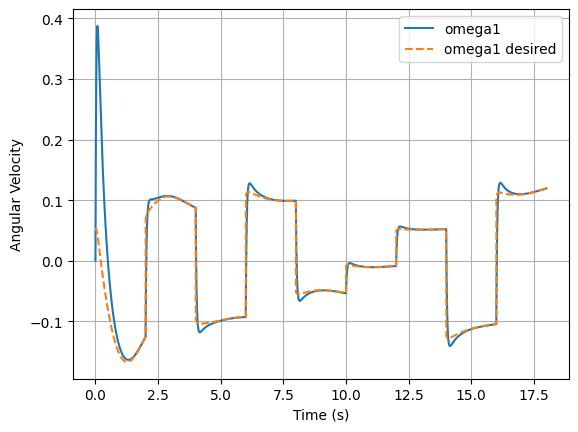

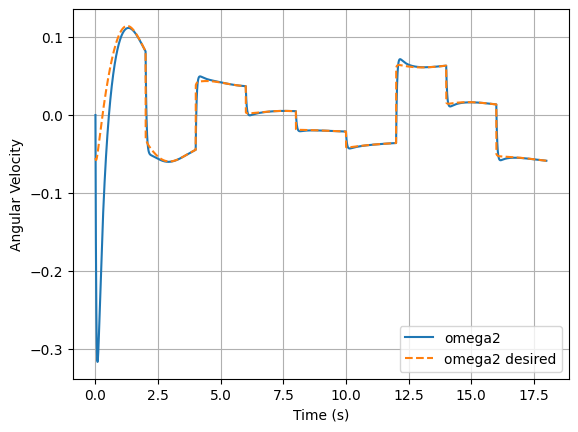

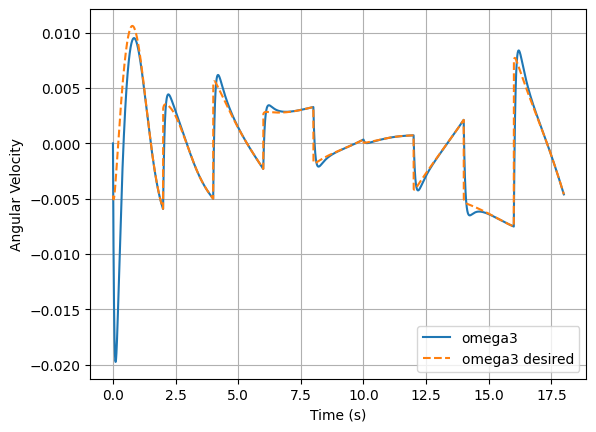

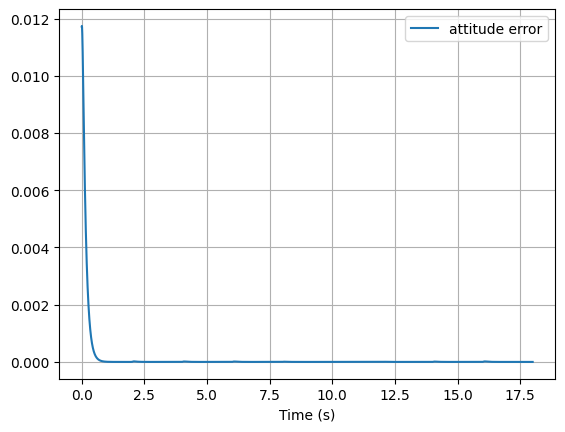

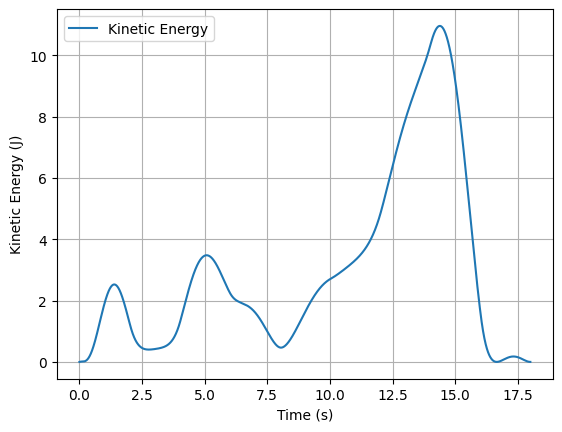

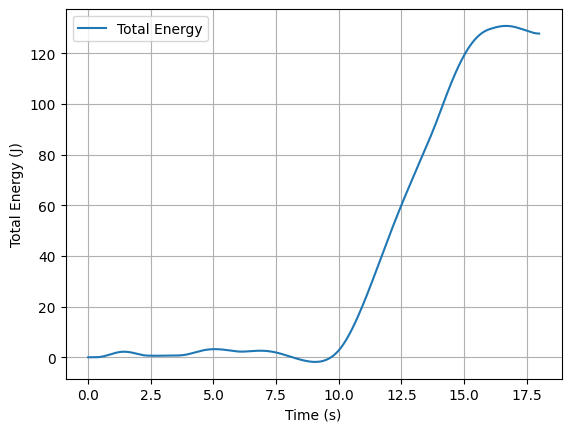

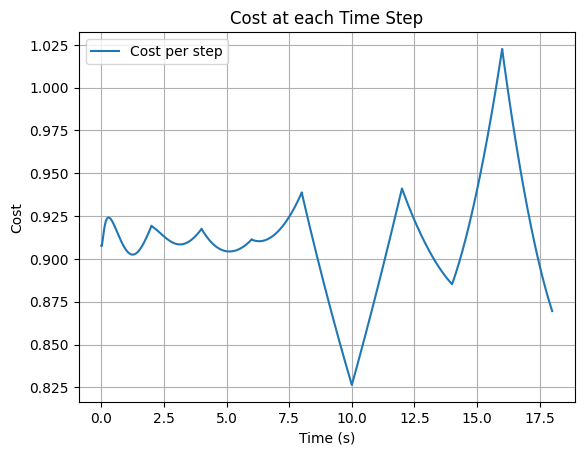

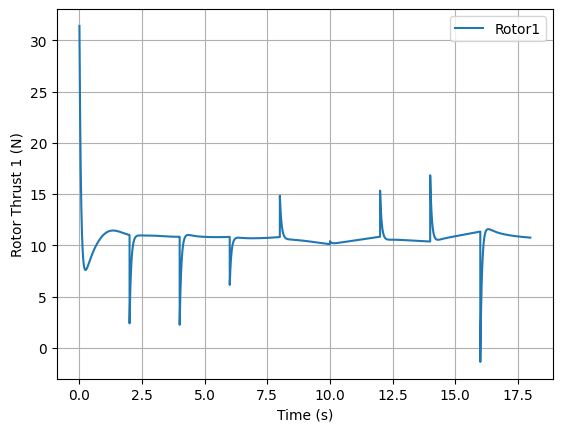

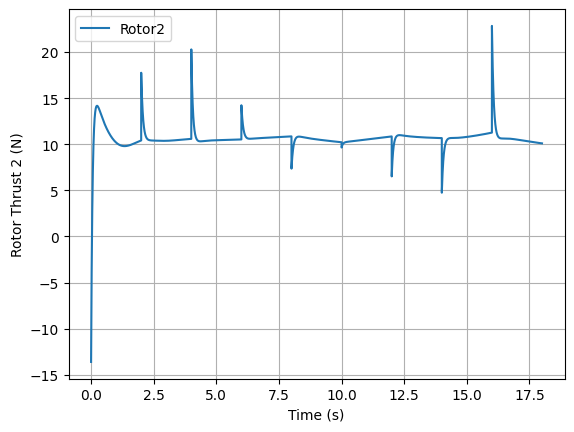

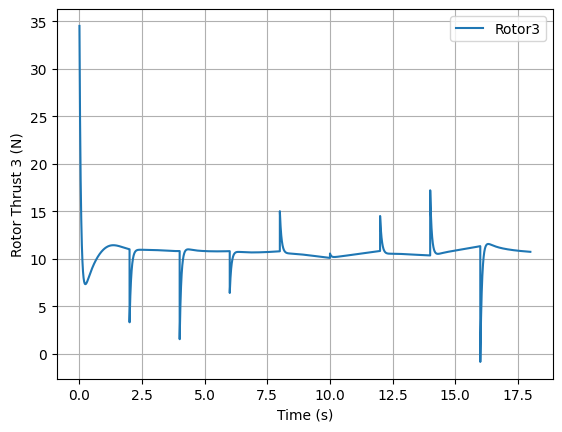

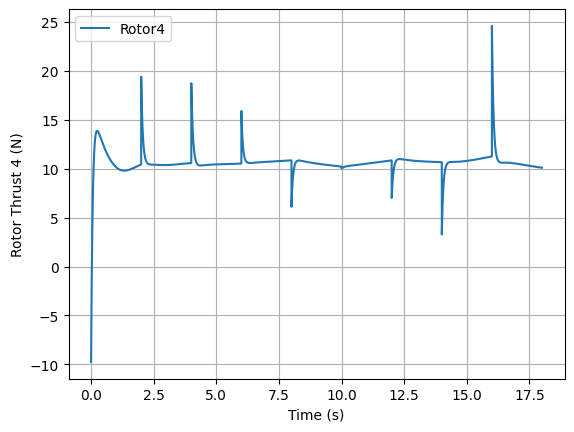

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_1, x_2, x_3, label="Trajectory")
ax.set_title("3D Position Trajectory")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
plt.legend()
plt.show()

plt.figure()
plt.plot(time_stamp, x_1, label="x")
plt.plot(time_stamp[1:], xd_1, label="x desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp, x_2, label="y")
plt.plot(time_stamp[1:], xd_2, label="y desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp, x_3, label="z")
plt.plot(time_stamp[1:], xd_3, label="z desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp, omega1, label="omega1")
plt.plot(time_stamp[1:], omegad1, label="omega1 desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp, omega2, label="omega2")
plt.plot(time_stamp[1:], omegad2, label="omega2 desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity")
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(time_stamp, omega3, label="omega3")
plt.plot(time_stamp[1:], omegad3, label="omega3 desired", linestyle= "dashed")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity")
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(time_stamp[1:], er, label="attitude error")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp[1:], kinetic_energy, label="Kinetic Energy")
plt.xlabel("Time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(time_stamp[1:], total_energy, label="Total Energy")
plt.xlabel("Time (s)")
plt.ylabel("Total Energy (J)")
plt.legend()
plt.grid()
plt.show()

# Plot Cost at each Time Step
plt.figure()
plt.plot(time_stamp[:-1], cost_array, label="Cost per step")
plt.xlabel("Time (s)")
plt.ylabel("Cost")
plt.title("Cost at each Time Step")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_stamp[1:], T1_list, label="Rotor1")
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 1 (N)")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(time_stamp[1:], T2_list, label="Rotor2")
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 2 (N)")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(time_stamp[1:], T3_list, label="Rotor3")
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 3 (N)")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(time_stamp[1:], T4_list, label="Rotor4")
plt.xlabel("Time (s)")
plt.ylabel("Rotor Thrust 4 (N)")
plt.grid()
plt.legend()
plt.show()